In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from debris_cover_smb import glac_dyn, constants, geospatial

In [3]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/ImjaLhotseShar/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/ImjaLhotseShar/SMB_data


In [4]:
ls 

20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vm_skiprate_1_gauss_fill51px_shpclip_1.tif
20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_1.tif
20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_1.tif
imja_correct_icecliff.geojson
imja_dh_aggregates.csv
imja_farinotti_2015-10-02_to_2016-10-29_agu_location_of_cliffs.gpkg
imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltcurve.png
imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv
imja_farinotti_2015-10-02_to_2016-10-29_divQ2_std_div.tif
imja_farinotti_2015-10-02_to_2016-10-29_divQ2.tif
imja_farinotti_2015-10-02_to_2016-10-29_downslope_dhdt.tif
imja_farinotti_2015-10-02_to_2016-10-29_eulerian_dhdt.tif
imja_farinotti_2015-10-02_to_2016-10-29_hotspot_location.gpkg
imja_farinot

In [5]:
eul_dhdt = 'imja_farinotti_2015-10-02_to_2016-10-29_eulerian_dhdt.tif'
lag_dhdt = 'imja_farinotti_2015-10-02_to_2016-10-29_lagrangian_dhdt.tif'
slope_corrected_lag_dhdt = 'imja_farinotti_2015-10-02_to_2016-10-29_slope_corrected_lagrangian_dhdt.tif'
smb_dhdt = 'imja_farinotti_2015-10-02_to_2016-10-29_smb_dhdt.tif'
dem1_fn = '../dem/20151002_0651_10200100457F0C00_1020010042C0CE00-DEM_2m.tif'
ds_list = warplib.memwarp_multi_fn([dem1_fn,eul_dhdt,lag_dhdt,slope_corrected_lag_dhdt,smb_dhdt],extent='last')
dem1,eul,lag,slope_corrected_lag,smb = [iolib.ds_getma(ds) for ds in ds_list]


Warping all inputs to the following:
Resolution: 2.0
Extent: [483653.0, 3084187.0, 499087.0, 3100893.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: ../dem/20151002_0651_10200100457F0C00_1020010042C0CE00-DEM_2m.tif
2 of 5: imja_farinotti_2015-10-02_to_2016-10-29_eulerian_dhdt.tif
3 of 5: imja_farinotti_2015-10-02_to_2016-10-29_lagrangian_dhdt.tif
4 of 5: imja_farinotti_2015-10-02_to_2016-10-29_slope_corrected_lagrangian_dhdt.tif
5 of 5: imja_farinotti_2015-10-02_to_2016-10-29_smb_dhdt.tif


In [6]:
common_mask = malib.common_mask([dem1,eul,lag,slope_corrected_lag,smb])
dem1,eul,lag,slope_corrected_lag,smb = [np.ma.array(ar,mask=common_mask) for ar in [dem1,eul,lag,slope_corrected_lag,smb]]

In [7]:
%matplotlib widget

<Axes: >

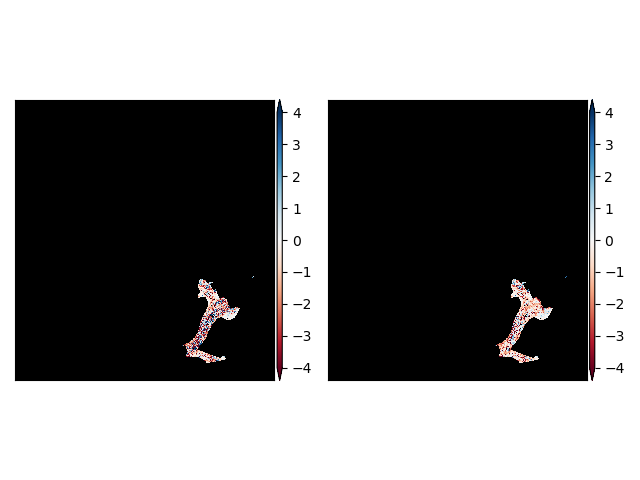

In [8]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
pltlib.iv(eul,ax=ax[0],cmap='RdBu',clim=(-4,4))
pltlib.iv(slope_corrected_lag,ax=ax[1],cmap='RdBu',clim=(-4,4))

In [9]:
def aggregate_different_dh_metrics(dem1,smb,lag,eul,slope_corrected_lag):
    bin_width = 50
    res = geolib.get_res(ds_list[0],square=True)
    z1 = dem1 
    z_bin_edges, z_bin_centers = malib.get_bins(z1, bin_width)
    z1_bin_counts, z1_bin_edges = np.histogram(z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * res[0] * res[1] / 1E6
    
    smb_bin_med = np.ma.masked_all_like(z1_bin_areas)
    np.ma.set_fill_value(smb_bin_med, np.nan)
    smb_bin_nmad = np.ma.masked_all_like(smb_bin_med)
    smb_bin_count = np.ma.masked_all_like(smb_bin_med)
    
    eul_bin_med = np.ma.masked_all_like(z1_bin_areas)
    np.ma.set_fill_value(eul_bin_med, np.nan)
    eul_bin_nmad = np.ma.masked_all_like(smb_bin_med)
    
    lag_bin_med = np.ma.masked_all_like(z1_bin_areas)
    np.ma.set_fill_value(lag_bin_med, np.nan)
    lag_bin_nmad = np.ma.masked_all_like(lag_bin_med)
    
    slope_lag_bin_med = np.ma.masked_all_like(z1_bin_areas)
    np.ma.set_fill_value(slope_lag_bin_med, np.nan)
    slope_lag_bin_nmad = np.ma.masked_all_like(slope_lag_bin_med)
    
    idx = np.digitize(z1,z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        #smb_sample
        dh_smb_samp = smb[(idx == bin_n+1)]
        smb_bin_med[bin_n] = np.round(malib.fast_median(dh_smb_samp),2)
        smb_bin_nmad[bin_n] = np.round(malib.mad(dh_smb_samp),2)
        smb_bin_count[bin_n] = np.ma.count(dh_smb_samp)
    
        #eul_sample
        dh_eul_samp = eul[(idx == bin_n+1)]
        eul_bin_med[bin_n] = np.round(malib.fast_median(dh_eul_samp),2)
        eul_bin_nmad[bin_n] = np.round(malib.mad(dh_eul_samp),2)
    
        #lag_sample
        dh_lag_samp = lag[(idx == bin_n+1)]
        lag_bin_med[bin_n] = np.round(malib.fast_median(dh_lag_samp),2)
        lag_bin_nmad[bin_n] = np.round(malib.mad(dh_lag_samp),2)
    
        #slope_lag_sample
        dh_slope_lag_samp = slope_corrected_lag[(idx == bin_n+1)]
        slope_lag_bin_med[bin_n] = np.round(malib.fast_median(dh_slope_lag_samp),2)
        slope_lag_bin_nmad[bin_n] = np.round(malib.mad(dh_slope_lag_samp),2)
    stats_df = pd.DataFrame({'z1_bin_centers':z_bin_centers,'eul_med':eul_bin_med,'eul_nmad':eul_bin_nmad,
                             'lag_med':lag_bin_med,'lag_nmad':lag_bin_nmad,
                             'slope_lag_med':slope_lag_bin_med,'slope_lag_nmad':slope_lag_bin_nmad,
                             'smb_med':smb_bin_med,'smb_nmad':smb_bin_nmad,'area':smb_bin_count*res[0]*res[1]*1e-6})
    return stats_df

In [10]:
imja_stats = aggregate_different_dh_metrics(dem1,smb,lag,eul,slope_corrected_lag)

In [11]:
imja_stats

,z1_bin_centers,eul_med,eul_nmad,lag_med,lag_nmad,slope_lag_med,slope_lag_nmad,smb_med,smb_nmad,area
0,4975.0,-0.63,1.89,-0.80,1.47,-0.60,1.43,-0.73,1.59,0.221772
1,5025.0,-0.94,1.81,-1.20,1.28,-0.91,1.23,-0.89,1.40,0.825112
2,5075.0,-1.00,2.14,-1.33,1.54,-0.92,1.47,-1.44,1.58,0.624012
3,5125.0,-0.48,2.29,-0.87,1.33,-0.42,1.33,-1.01,1.49,0.694260
4,5175.0,-0.81,1.63,-1.43,1.06,-0.80,0.89,-1.92,1.55,1.011248
5,5225.0,-0.49,1.26,-2.22,2.05,-0.62,0.96,-0.60,1.24,0.479608
6,5275.0,-0.24,0.74,-0.58,0.77,-0.23,0.71,-0.31,0.92,0.596824
7,5325.0,-0.26,0.92,-0.64,1.00,-0.29,0.88,0.27,1.10,0.417372
8,5375.0,0.36,2.05,-0.10,2.70,0.06,2.21,0.45,2.02,0.088244
9,5425.0,-0.07,1.44,0.13,2.26,0.03,1.40,0.34,1.49,0.061460


In [12]:
imja_stats.to_csv('imja_dh_aggregates.csv')

In [13]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Ngozumpa/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Ngozumpa/SMB_data


In [14]:
eul_dhdt = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_eulerian_dhdt.tif'
lag_dhdt = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_lagrangian_dhdt.tif'
slope_corrected_lag_dhdt = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_slope_corrected_lagrangian_dhdt.tif'
smb_dhdt = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_smb_dhdt.tif'
dem1_fn = '../dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif'
ds_list = warplib.memwarp_multi_fn([dem1_fn,eul_dhdt,lag_dhdt,slope_corrected_lag_dhdt,smb_dhdt],extent='last')
dem1,eul,lag,slope_corrected_lag,smb = [iolib.ds_getma(ds) for ds in ds_list]
common_mask = malib.common_mask([dem1,eul,lag,slope_corrected_lag,smb])
dem1,eul,lag,slope_corrected_lag,smb = [np.ma.array(ar,mask=common_mask) for ar in [dem1,eul,lag,slope_corrected_lag,smb]]



Warping all inputs to the following:
Resolution: 2.0
Extent: [464833.0, 3085251.0, 477745.0, 3104071.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: ../dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif
2 of 5: ngozumpa_farinotti_2012-12-23_to_2015-01-15_eulerian_dhdt.tif
3 of 5: ngozumpa_farinotti_2012-12-23_to_2015-01-15_lagrangian_dhdt.tif
4 of 5: ngozumpa_farinotti_2012-12-23_to_2015-01-15_slope_corrected_lagrangian_dhdt.tif
5 of 5: ngozumpa_farinotti_2012-12-23_to_2015-01-15_smb_dhdt.tif


In [15]:
ngozumpa_stats = aggregate_different_dh_metrics(dem1,smb,lag,eul,slope_corrected_lag)

In [16]:
ngozumpa_stats.to_csv('ngozumpa_dh_aggregates.csv')

<Axes: >

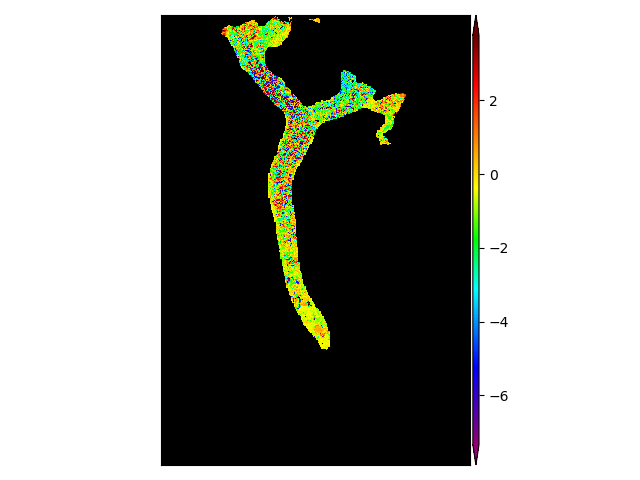

In [17]:
f,ax = plt.subplots()
pltlib.iv(eul,ax=ax)

In [18]:
ngozumpa_stats

,z1_bin_centers,eul_med,eul_nmad,lag_med,lag_nmad,slope_lag_med,slope_lag_nmad,smb_med,smb_nmad,area
0,4675.0,-0.37,0.43,-0.38,0.40,-0.37,0.41,-0.40,0.43,1.187632
1,4725.0,-0.53,0.64,-0.54,0.52,-0.53,0.52,-0.58,0.63,1.598996
2,4775.0,-0.44,0.97,-0.48,0.67,-0.40,0.68,-0.59,0.73,1.273080
3,4825.0,-0.40,1.45,-0.48,0.85,-0.37,0.83,-0.85,0.93,1.428232
4,4875.0,-0.58,2.11,-0.85,0.79,-0.57,0.78,-0.90,0.84,1.432448
5,4925.0,-0.86,2.08,-1.05,1.09,-0.71,1.05,-1.76,1.43,2.145792
6,4975.0,-1.44,2.01,-2.28,1.22,-1.40,1.09,-2.25,2.05,1.691348
7,5025.0,-1.62,2.29,-2.92,1.30,-1.55,1.12,-2.72,2.43,1.713740
8,5075.0,-1.50,2.59,-2.93,1.69,-1.59,1.37,-1.62,2.45,1.450784
9,5125.0,-1.15,2.60,-2.68,1.15,-1.11,1.01,-4.27,2.16,0.857476


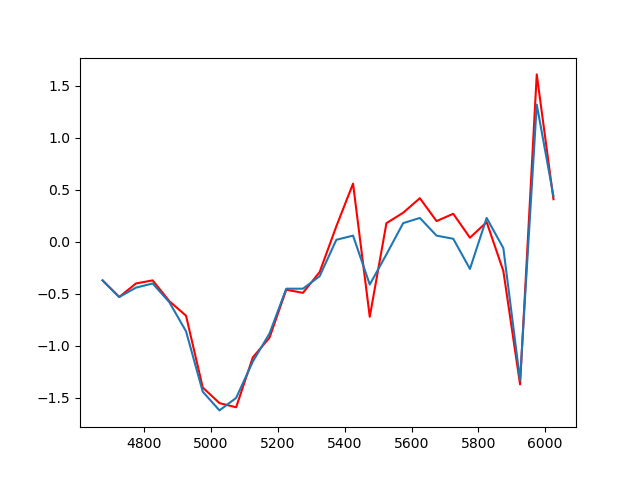

In [19]:
f,ax = plt.subplots()
ax.plot(ngozumpa_stats.z1_bin_centers,ngozumpa_stats.slope_lag_med,c='red')
ax.plot(ngozumpa_stats.z1_bin_centers,ngozumpa_stats.eul_med)

In [20]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Khumbu/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Khumbu/SMB_data


In [21]:
eul_dhdt = 'khumbu_farinotti_2015-11-02_to_2016-10-25_eulerian_dhdt.tif'
lag_dhdt = 'khumbu_farinotti_2015-11-02_to_2016-10-25_lagrangian_dhdt.tif'
slope_corrected_lag_dhdt = 'khumbu_farinotti_2015-11-02_to_2016-10-25_slope_corrected_lagrangian_dhdt.tif'
smb_dhdt = 'khumbu_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif'
dem1_fn = '../dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif'
ds_list = warplib.memwarp_multi_fn([dem1_fn,eul_dhdt,lag_dhdt,slope_corrected_lag_dhdt,smb_dhdt],extent='last')
dem1,eul,lag,slope_corrected_lag,smb = [iolib.ds_getma(ds) for ds in ds_list]
common_mask = malib.common_mask([dem1,eul,lag,slope_corrected_lag,smb])
dem1,eul,lag,slope_corrected_lag,smb = [np.ma.array(ar,mask=common_mask) for ar in [dem1,eul,lag,slope_corrected_lag,smb]]



Warping all inputs to the following:
Resolution: 2.0
Extent: [474665.0, 3090517.0, 488435.0, 3100917.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: ../dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif
2 of 5: khumbu_farinotti_2015-11-02_to_2016-10-25_eulerian_dhdt.tif
3 of 5: khumbu_farinotti_2015-11-02_to_2016-10-25_lagrangian_dhdt.tif
4 of 5: khumbu_farinotti_2015-11-02_to_2016-10-25_slope_corrected_lagrangian_dhdt.tif
5 of 5: khumbu_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif


In [22]:
khumbu_stats = aggregate_different_dh_metrics(dem1,smb,lag,eul,slope_corrected_lag)

In [23]:
khumbu_stats.to_csv('khumbu_dh_aggregates.csv')

In [24]:
khumbu_stats

,z1_bin_centers,eul_med,eul_nmad,lag_med,lag_nmad,slope_lag_med,slope_lag_nmad,smb_med,smb_nmad,area
0,4875.0,0.05,0.81,0.01,0.74,0.04,0.74,-0.15,0.82,0.362176
1,4925.0,-0.32,0.79,-0.34,0.64,-0.32,0.65,-0.43,0.80,0.924952
2,4975.0,-0.72,1.65,-0.93,1.25,-0.72,1.20,-1.29,1.31,0.523472
3,5025.0,-1.04,2.55,-1.60,1.21,-1.05,1.17,-1.97,1.47,0.376928
4,5075.0,-1.16,2.15,-1.54,1.32,-1.12,1.34,-2.17,1.43,0.717656
5,5125.0,-1.06,2.44,-1.71,1.44,-1.00,1.39,-2.21,1.63,0.853220
6,5175.0,-1.29,2.46,-2.43,1.70,-1.36,1.36,-2.37,2.28,1.003988
7,5225.0,-1.02,2.32,-2.24,1.79,-1.18,1.26,-3.61,2.30,1.081600
8,5275.0,-1.11,2.61,-2.80,2.16,-1.09,1.20,-1.39,1.59,1.002860
9,5325.0,-0.50,1.91,-2.65,3.61,-0.77,1.47,-0.22,1.17,0.543392


In [28]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/BlackChangriNup/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/BlackChangriNup/SMB_data


In [29]:
eul_dhdt = 'black_changri_nup_farinotti_2015-11-02_to_2016-10-25_eulerian_dhdt.tif'
lag_dhdt = 'black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lagrangian_dhdt.tif'
slope_corrected_lag_dhdt = 'black_changri_nup_farinotti_2015-11-02_to_2016-10-25_slope_corrected_lagrangian_dhdt.tif'
smb_dhdt = 'black_changri_nup_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif'
dem1_fn = '../dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif'
ds_list = warplib.memwarp_multi_fn([dem1_fn,eul_dhdt,lag_dhdt,slope_corrected_lag_dhdt,smb_dhdt],extent='last')
dem1,eul,lag,slope_corrected_lag,smb = [iolib.ds_getma(ds) for ds in ds_list]
common_mask = malib.common_mask([dem1,eul,lag,slope_corrected_lag,smb])
dem1,eul,lag,slope_corrected_lag,smb = [np.ma.array(ar,mask=common_mask) for ar in [dem1,eul,lag,slope_corrected_lag,smb]]



Warping all inputs to the following:
Resolution: 2.0
Extent: [474665.0, 3090517.0, 488435.0, 3100917.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: ../dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif
2 of 5: black_changri_nup_farinotti_2015-11-02_to_2016-10-25_eulerian_dhdt.tif
3 of 5: black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lagrangian_dhdt.tif
4 of 5: black_changri_nup_farinotti_2015-11-02_to_2016-10-25_slope_corrected_lagrangian_dhdt.tif
5 of 5: black_changri_nup_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif


In [30]:
bcn_stats = aggregate_different_dh_metrics(dem1,smb,lag,eul,slope_corrected_lag)

In [31]:
bcn_stats.to_csv('black_changri_nup_dh_aggregates.csv')

In [32]:
bcn_stats

,z1_bin_centers,eul_med,eul_nmad,lag_med,lag_nmad,slope_lag_med,slope_lag_nmad,smb_med,smb_nmad,area
0,5225.0,-0.50,0.35,-0.71,0.31,-0.51,0.31,-0.52,0.31,0.002112
1,5275.0,-0.50,0.43,-0.58,0.44,-0.48,0.40,-0.56,0.39,0.088928
2,5325.0,-0.76,0.54,-0.84,0.55,-0.76,0.52,-1.12,0.63,0.303260
3,5375.0,-0.84,0.91,-1.14,0.65,-0.88,0.64,-1.30,0.80,0.297956
4,5425.0,-0.53,0.94,-0.96,0.67,-0.50,0.65,-1.03,0.89,0.331820
5,5475.0,-0.39,1.08,-1.29,0.61,-0.35,0.55,-0.48,0.64,0.247048
6,5525.0,-0.44,0.65,-1.22,0.53,-0.46,0.50,-0.37,0.69,0.318324
7,5575.0,-0.41,0.91,-1.26,1.19,-0.26,0.81,0.10,1.05,0.244536
8,5625.0,-1.57,2.20,-6.43,3.66,-1.63,1.83,-1.66,1.79,0.064616
9,5675.0,0.61,2.61,-2.48,5.75,0.39,2.79,1.93,4.75,0.062608


In [33]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Langtang/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Langtang/SMB_data


In [34]:
eul_dhdt = 'langtang_farinotti_2015-02-22_to_2016-01-07_eulerian_dhdt.tif'
lag_dhdt = 'langtang_farinotti_2015-02-22_to_2016-01-07_lagrangian_dhdt.tif'
slope_corrected_lag_dhdt = 'langtang_farinotti_2015-02-22_to_2016-01-07_slope_corrected_lagrangian_dhdt.tif'
smb_dhdt = 'langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt.tif'
dem1_fn = '../dem/20150222_0504_1040010008B92D00_10400100087E2400-DEM_2m_align.tif'
ds_list = warplib.memwarp_multi_fn([dem1_fn,eul_dhdt,lag_dhdt,slope_corrected_lag_dhdt,smb_dhdt],extent='last')
dem1,eul,lag,slope_corrected_lag,smb = [iolib.ds_getma(ds) for ds in ds_list]
common_mask = malib.common_mask([dem1,eul,lag,slope_corrected_lag,smb])
dem1,eul,lag,slope_corrected_lag,smb = [np.ma.array(ar,mask=common_mask) for ar in [dem1,eul,lag,slope_corrected_lag,smb]]



Warping all inputs to the following:
Resolution: 2.0
Extent: [366377.0, 3120253.0, 375921.0, 3140895.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: ../dem/20150222_0504_1040010008B92D00_10400100087E2400-DEM_2m_align.tif
2 of 5: langtang_farinotti_2015-02-22_to_2016-01-07_eulerian_dhdt.tif
3 of 5: langtang_farinotti_2015-02-22_to_2016-01-07_lagrangian_dhdt.tif
4 of 5: langtang_farinotti_2015-02-22_to_2016-01-07_slope_corrected_lagrangian_dhdt.tif
5 of 5: langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt.tif


In [35]:
langtang_stats = aggregate_different_dh_metrics(dem1,smb,lag,eul,slope_corrected_lag)

In [36]:
langtang_stats.to_csv('langtang_dh_aggregates.csv')

In [37]:
langtang_stats

,z1_bin_centers,eul_med,eul_nmad,lag_med,lag_nmad,slope_lag_med,slope_lag_nmad,smb_med,smb_nmad,area
0,4475.0,-0.24,0.78,-0.43,0.55,-0.26,0.57,-1.02,0.78,0.169672
1,4525.0,-0.12,1.01,-0.33,0.64,-0.15,0.64,-0.36,0.77,0.493284
2,4575.0,-0.15,1.23,-0.38,0.65,-0.17,0.64,-0.12,0.84,0.719844
3,4625.0,-0.45,1.28,-0.61,0.93,-0.48,0.88,-0.60,0.92,1.507640
4,4675.0,-0.49,1.33,-0.60,0.79,-0.44,0.74,-0.50,0.91,1.197608
5,4725.0,-0.44,1.29,-0.65,0.90,-0.48,0.84,-0.68,1.03,1.265848
6,4775.0,-0.52,1.25,-0.70,0.85,-0.57,0.80,-0.67,0.91,1.374512
7,4825.0,-0.34,1.66,-0.59,1.18,-0.40,1.10,-0.53,1.17,1.027088
8,4875.0,-0.19,1.71,-0.42,1.14,-0.19,1.10,-0.56,1.34,0.895060
9,4925.0,-0.54,1.88,-0.78,1.31,-0.47,1.21,-0.99,1.47,0.851260


In [38]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Lirung/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Lirung/SMB_data


In [39]:
eul_dhdt = 'lirung_farinotti_2016-11-06_to_2017-12-22_eulerian_dhdt.tif'
lag_dhdt = 'lirung_farinotti_2016-11-06_to_2017-12-22_lagrangian_dhdt.tif'
slope_corrected_lag_dhdt = 'lirung_farinotti_2016-11-06_to_2017-12-22_slope_corrected_lagrangian_dhdt.tif'
smb_dhdt = 'lirung_farinotti_2016-11-06_to_2017-12-22_smb_dhdt.tif'
dem1_fn = '../dem/20161106_0456_103001005FAB7A00_103001005F7EBB00-DEM_2m_align.tif'
ds_list = warplib.memwarp_multi_fn([dem1_fn,eul_dhdt,lag_dhdt,slope_corrected_lag_dhdt,smb_dhdt],extent='last')
dem1,eul,lag,slope_corrected_lag,smb = [iolib.ds_getma(ds) for ds in ds_list]
common_mask = malib.common_mask([dem1,eul,lag,slope_corrected_lag,smb])
dem1,eul,lag,slope_corrected_lag,smb = [np.ma.array(ar,mask=common_mask) for ar in [dem1,eul,lag,slope_corrected_lag,smb]]



Warping all inputs to the following:
Resolution: 2.0
Extent: [354137.0, 3121511.0, 362167.0, 3130547.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: ../dem/20161106_0456_103001005FAB7A00_103001005F7EBB00-DEM_2m_align.tif
2 of 5: lirung_farinotti_2016-11-06_to_2017-12-22_eulerian_dhdt.tif
3 of 5: lirung_farinotti_2016-11-06_to_2017-12-22_lagrangian_dhdt.tif
4 of 5: lirung_farinotti_2016-11-06_to_2017-12-22_slope_corrected_lagrangian_dhdt.tif
5 of 5: lirung_farinotti_2016-11-06_to_2017-12-22_smb_dhdt.tif


In [40]:
lirung_stats = aggregate_different_dh_metrics(dem1,smb,lag,eul,slope_corrected_lag)

In [41]:
lirung_stats.to_csv('lirung_dh_aggregates.csv')

In [42]:
lirung_stats

,z1_bin_centers,eul_med,eul_nmad,lag_med,lag_nmad,slope_lag_med,slope_lag_nmad,smb_med,smb_nmad,area
0,3975.0,-0.18,0.14,-0.21,0.15,-0.18,0.14,-0.24,0.19,0.165980
1,4025.0,-1.16,0.85,-1.46,0.81,-1.18,0.83,-1.45,1.07,0.069012
2,4075.0,-0.57,0.46,-0.86,0.43,-0.58,0.42,-0.75,0.46,0.134036
3,4125.0,-0.45,0.42,-0.78,0.42,-0.47,0.36,-0.55,0.35,0.138712
4,4175.0,-0.54,0.50,-0.92,0.39,-0.61,0.36,-0.87,0.51,0.146340
5,4225.0,-2.10,1.70,-2.36,1.46,-2.11,1.58,-2.15,1.86,0.318792
6,4275.0,-4.47,2.73,-5.17,2.29,-4.51,2.54,-4.55,3.35,0.226608
7,4325.0,-4.23,1.41,-4.97,1.57,-4.30,1.37,-3.87,1.67,0.037616
8,4375.0,0.30,0.77,-0.53,0.70,0.34,0.72,0.84,1.01,0.005880
9,4425.0,0.29,0.33,-0.20,0.37,0.46,0.37,0.56,0.44,0.008584


## Final plot

In [47]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data


In [74]:
agg_stat_fn1 = 'Lirung/SMB_data/lirung_dh_aggregates.csv'
agg_stat_fn2 = 'Langtang/SMB_data/langtang_dh_aggregates.csv'
agg_stat_fn3 = 'Ngozumpa/SMB_data/ngozumpa_dh_aggregates.csv'
agg_stat_fn4 = 'BlackChangriNup/SMB_data/black_changri_nup_dh_aggregates.csv'
agg_stat_fn5 = 'Khumbu/SMB_data/khumbu_dh_aggregates.csv'
agg_stat_fn6 = 'ImjaLhotseShar/SMB_data/imja_dh_aggregates.csv'
stat_list = [agg_stat_fn1,agg_stat_fn2,agg_stat_fn3,agg_stat_fn4,agg_stat_fn5,agg_stat_fn6]

In [97]:
#f,ax = plt.subplots()
def plot_agg(melt_df,ax):
    
    ax.plot(melt_df.z1_bin_centers,melt_df.eul_med,color='red',label=r'$Eul.\; \frac{dh}{dt}$')
    ax.fill_between(melt_df.z1_bin_centers,melt_df.eul_med-melt_df.eul_nmad,
                        melt_df.eul_med+melt_df.eul_nmad,color='red',alpha=0.1)
    ax.plot(melt_df.z1_bin_centers,melt_df.lag_med,color='blue',label=r'$Lag.\; \frac{Dh}{Dt}$')
    #ax.fill_between(melt_df.z1_bin_centers,melt_df.lag_med-melt_df.lag_nmad,
     #                   melt_df.lag_med+melt_df.lag_nmad,color='blue',alpha=0.1)
    ax.plot(melt_df.z1_bin_centers,melt_df.slope_lag_med,color='black',label=r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h}$')
    ax.fill_between(melt_df.z1_bin_centers,melt_df.slope_lag_med-melt_df.slope_lag_nmad,
                        melt_df.slope_lag_med+melt_df.slope_lag_nmad,color='black',alpha=0.3)
    ax.plot(melt_df.z1_bin_centers,melt_df.smb_med,color='green',label=r'$\frac{\dot{b}}{\rho}$ ')
    #ax.fill_between(melt_df.z1_bin_centers,melt_df.smb_med-melt_df.smb_nmad,
     #                   melt_df.smb_med+melt_df.smb_nmad,color='black',alpha=0.1)
    ax.axhline(0,linestyle='--',c='k')
    ax.set_xlabel("Elevation (m)")
    ax.set_ylabel("Elevation change (m/yr)")
    

In [98]:
titles = ['A. Lirung', 'B. Langtang', 'C. Ngozumpa', 'D. Black Changri Nup', 'E. Khumbu', 'F. Imja Lhotse Shar']

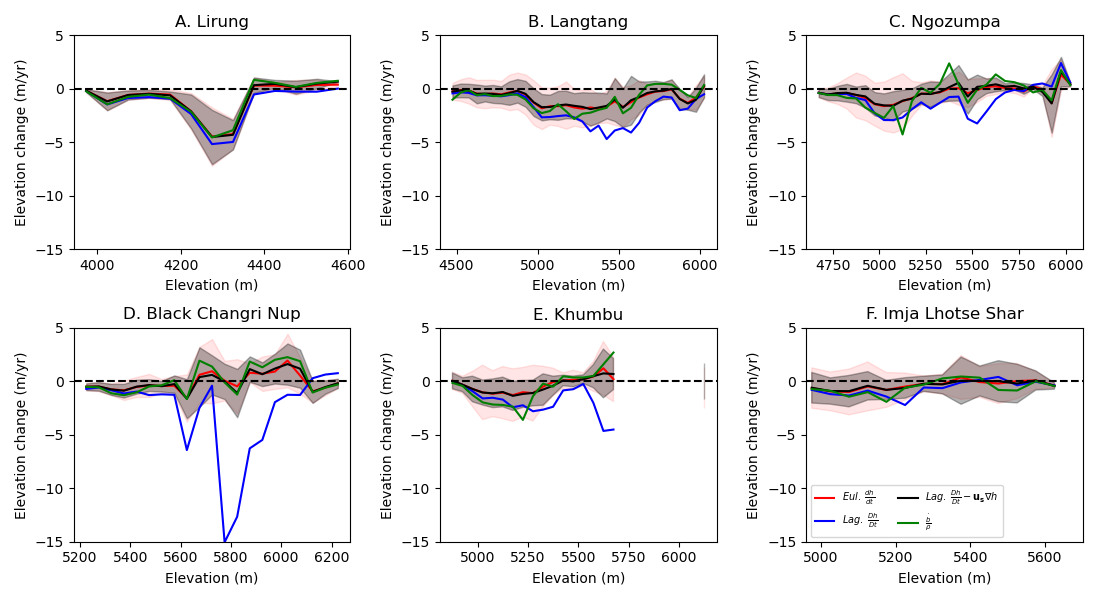

In [101]:
f,axa = plt.subplots(2,3,figsize=(11,6))
for idx,ax in enumerate(axa.ravel()):
    melt_df = pd.read_csv(stat_list[idx])
    plot_agg(melt_df,ax)
    ax.set_title(titles[idx])
    if idx == 5:
        ax.set_xlim(4960,5701)
        ax.legend(prop={'size': 7},ncol=2)
    ax.set_ylim(-15,5)
    
plt.tight_layout()
f.savefig('/nobackup/sbhusha1/chapter2/figures/profile_from_different_components.png',dpi=300,bbox_inches='tight',pad_inches=0.1)